# Preprocessing Dataset

데이터를 모델에 넣기 전에 먼저 신호에 대해 전처리 작업을 해줄 필요가 있다.

**1. Filtering**
- PPG는 0.5-8.0Hz 사이의 주파수를 가지는 광신호이다. 그러므로 이를 cutoff로 하여서 BPF를 걸어주는 것을 고려할 필요가 있다.
- `Analysis: An optimal filter for short photoplethysmogram signals` 라는 논문에서는 `4th order Chebyshev II filter`가 단기 PPG에서 제일 좋은 성능을 보인다고 설명하고 있다.
- `Evaluation of Different Machine Learning Models for Photoplethysmogram Signal Artifact Detection` 라는 논문에서는 `Equiripple FIR filter`를 이용해서 필터링을 수행하였다.

**2. (optional) Resampling**
- 이는 선택사항이다. 데이터의 연산량을 줄이면서 좋은 결과를 낼 수 있는 수준이 어느 정도인지 확인할 수 있다.

**3. Windowing**
- 전체 신호에 대해서 필터링이 입혀졌다면 해당 신호를 일정 간격으로 잘라낸다. 분당 호흡수에 대응시킬 것이므로 1분 PPG를 분당 호흡수와 묶으면 되겠다.
- 본 신호의 양끝 경계 지점의 정보도 활용하기 위해 Overlap 을 고려한다.

**4. (optional) Signal Quality Indexing**
- 이는 선택사항이다. 구하여 낸 샘플들 중에서 샘플의 품질이 떨어지는 것을 임의의 기준으로 걸러낸다.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '../../DataLake/stMary'

subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
males = subjects.loc[subjects['gender']=='M']
females = subjects.loc[subjects['gender']=='F']
patients = subjects.loc[subjects['diagnosis']!='0']
volunteers = subjects.loc[subjects['diagnosis']=='0']

`10_EDA_StMary.ipynb`에 따르면 남자와 여자 사이에는 신호 간에 큰 차이가 없지만, 환자와 건강한 자원자 사이에는 차이가 존재하는 것으로 확인된다.

그러므로 지금은 환자만을 대상으로 전처리 작업을 수행하는 것으로 해보자.

pleth는 int64 타입으로 기록되었다.

In [2]:
rand_idx = list(range(100))
random.seed(42)
test_idx = random.sample(rand_idx, k=20)
train_idx = list(set(rand_idx) - set(test_idx))
print(train_idx, test_idx)

[0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 72, 73, 74, 76, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99] [81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11, 75, 54, 4, 27, 29, 64, 77, 71]


In [3]:
train_patients = patients.iloc[train_idx]
test_patients = patients.iloc[test_idx]

성모병원의 환자데이터를 학습용과 실험용으로 구분하고 각각 80%:20%으로 구분한다.

다시 학습용 데이터에서 훈련용과 검증용을 각각 80%:20%로 구분한다.

왜 이렇게 구분하냐 하면 Validation과 Test 둘의 차이점 때문이다.

Validation과 Test 둘의 공통점은 둘 다 모델을 학습시키지 않는다는 것이다.

하지만 Validation은 모델의 학습에 관여하기는 한다. 반면에 Test는 모델의 학습의 어떠한 것에도 일절 관여하지 않고 오직 최종 성능 평가만을 진행한다.

In [4]:
targets = patients
pleths = [pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values for sid in targets.id.unique()]
resps = [pd.read_csv(f'{DATA_PATH}/{sid}/respirationTimeline.csv', header=None, names=['sid', 'offset']) for sid in targets.id.unique()]

# Before filtering: Check NaN
for pleth in pleths:
    if any(np.isnan(pleth)):
        print('check')

# Before filtering: Convert type as np.int16
pleths = list(map(lambda pleth: pleth.astype(np.int16), pleths))

## 1. Filtering

가장 기본적인 FIR BPF를 이용해서 필터링을 진행한다.

In [5]:
import multiprocessing
from scipy import signal, fft

In [6]:
taps = signal.firwin(numtaps=1800, cutoff=[0.1, 0.4], window='hamming', pass_zero=False, fs=125)
w, h = signal.freqz(taps)

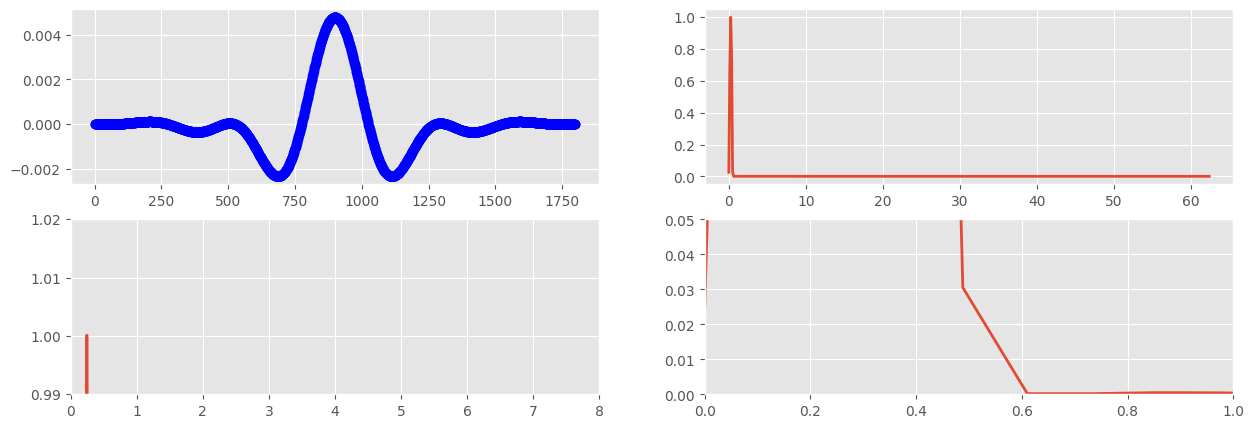

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15,5))
axs[0][0].plot(taps, 'bo-', linewidth=2)
axs[0][1].plot(w/np.pi*125/2.0, np.abs(h), linewidth=2)
axs[1][0].plot(w/np.pi*125/2.0, np.abs(h), linewidth=2)
axs[1][0].set_xlim(0, 8)
axs[1][0].set_ylim(0.990, 1.02)
axs[1][1].plot(w/np.pi*125/2.0, np.abs(h), linewidth=2)
axs[1][1].set_xlim(0, 1)
axs[1][1].set_ylim(0, 0.05)
plt.show()

In [8]:
pool = multiprocessing.Pool(processes=40)
filtered_pleths = pool.starmap(signal.filtfilt, [(taps, 1.0, pleth) for pleth in pleths])
pool.close()
pool.join()

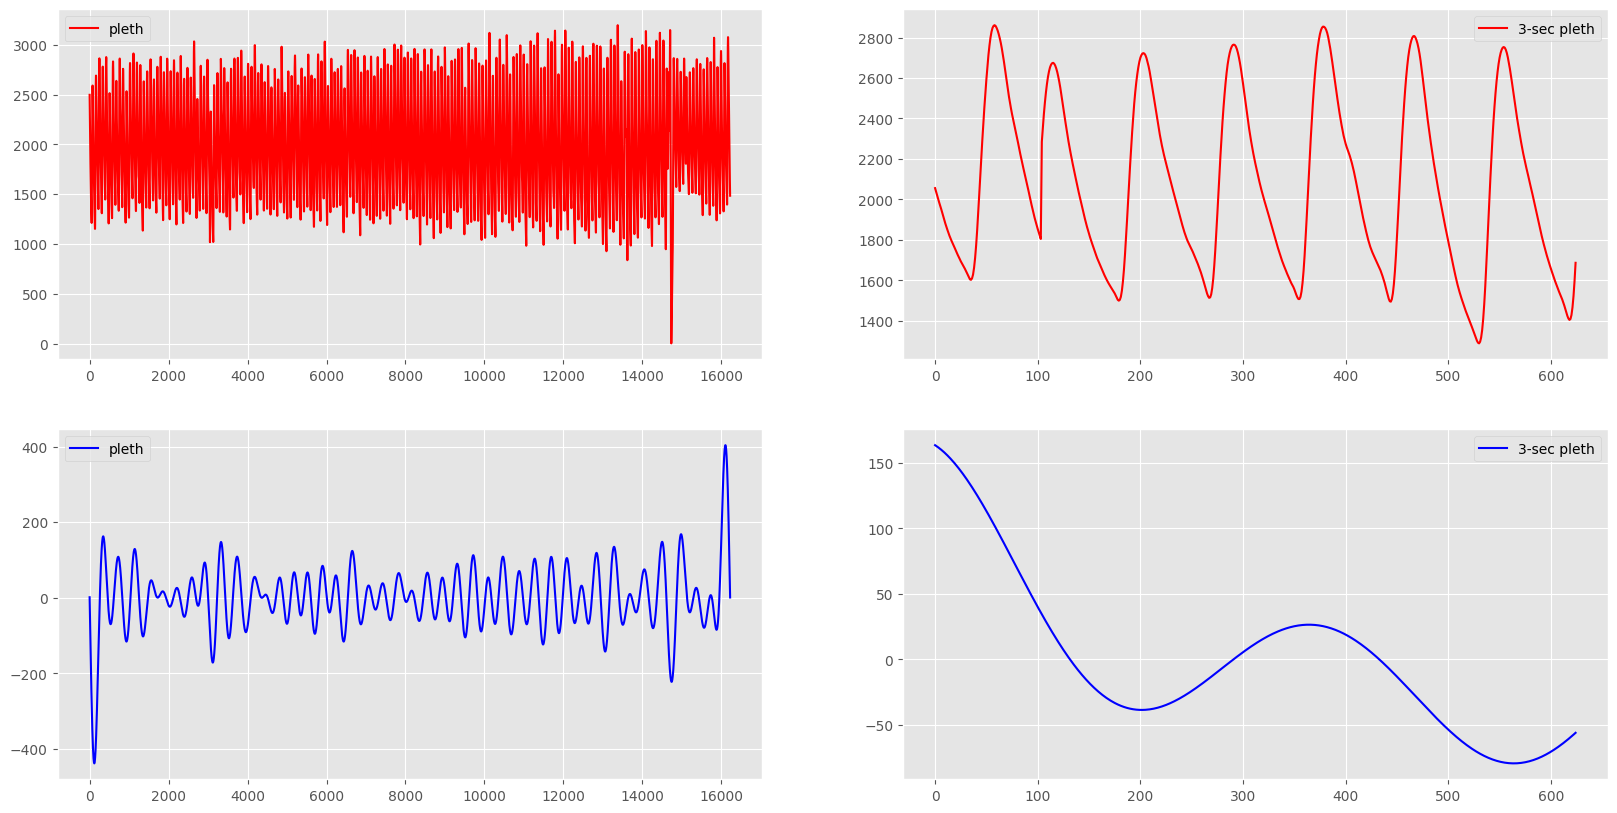

In [9]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].plot(pleths[-1], label='pleth', color='r')
axs[0][0].legend()
axs[0][1].plot(pleths[-1][125*120:125*125], label='3-sec pleth', color='r')
axs[0][1].legend()
axs[1][0].plot(filtered_pleths[-1], label='pleth', color='b')
axs[1][0].legend()
axs[1][1].plot(filtered_pleths[-1][125*120:125*125], label='3-sec pleth', color='b')
axs[1][1].legend()
plt.show()

In [10]:
# Equirriple FIR filter 는 여기에 좀 더 가깝지만 내가 아직 다룰 줄 모른다.
# band = [0.5, 8.0]
# trans_width = 0.01
# edges = [0, band[0]-trans_width, band[0], band[1], band[1]+trans_width, 125/2.0]
# taps = signal.remez(300, edges, [0, 1, 0], fs=125)
# w, h = signal.freqz(taps, [1], fs=125)

# fig, axs = plt.subplots(2, 1, figsize=(20,5))
# axs[0].plot(taps, 'bo-', linewidth=2)
# axs[1].plot(w, 20*np.log10(np.abs(h)), linewidth=2)
# plt.show()

## 2. Windowing

In [10]:
def generate_dataset(arg_pleths, arg_resps, fs=125, shift_factor=4):
    import copy
    dataset = []
    resp_dat = []
    pleth_dat = []
    window_size = fs * 60 # 7500
    shift = int(window_size/shift_factor) # 1875
    samples_len = len(arg_pleths)

    cpy_resps = copy.deepcopy(arg_resps)
    cpy_pleths = copy.deepcopy(arg_pleths)

    for i in range(samples_len):
        rr = cpy_resps[i]; ppg = cpy_pleths[i]

        rr['offset'] = (rr['offset']-rr['offset'].min())/1000
        size_lim = int(fs * np.ceil(rr['offset'].max()))
        ppg = ppg[:size_lim]
        shift_n_times = int((len(ppg)-window_size)/shift)+1

        samp_rr = [len(rr.loc[ (rr['offset']>=0+(int(shift/fs)*i)) & ((rr['offset']<int(window_size/fs)+(int(shift/fs)*i))) ]) for i in range(shift_n_times)]
        samp_ppg = [ppg[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]

        for i in range(len(samp_ppg)):
            pleth_dat.append(samp_ppg[i])
            resp_dat.append(samp_rr[i])

    return np.array(pleth_dat), np.array(resp_dat)

In [16]:
dataset = generate_dataset(filtered_pleths, resps, shift_factor=60)

In [21]:
dataset[0].shape, dataset[1].shape

((6508, 7500), (6508,))

In [22]:
print(dataset[1].min(), dataset[1].max())
# print(dataset.shape)
# print(dataset[:5][:])
# print(len(dataset[0][0]))

6 33


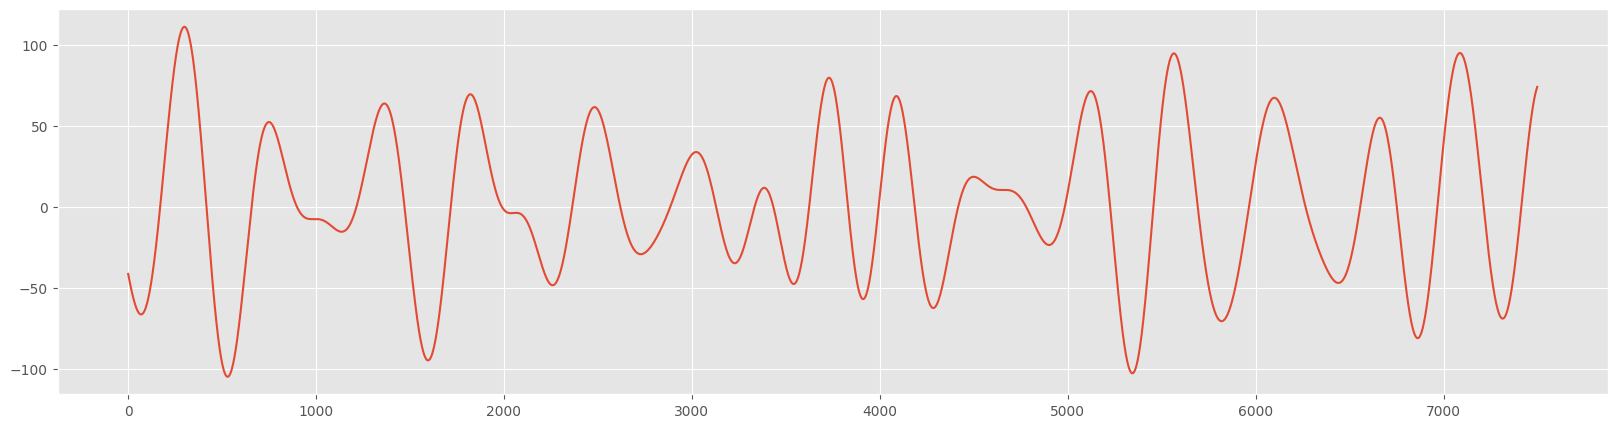

In [24]:
plt.figure(figsize=(20,5))
plt.plot(dataset[0][100])
plt.show()

In [15]:
# total 6508
# train 5224
# test 1284
len(dataset)

1284

## Save Dataset

`20_230517_sliced_filt_patient_stmary`
- Saved from file no.20
- Saved at 23/05/17
- FIR BPF [0.5-8]Hz
- Window size = 125 * 60 = 7500 samples
- RESP 1 sample/min
- no other option

In [16]:
# np.save(f'../../DataWarehouse/stMary_RRpo/20_230517_sliced_filt_patient_stmary.npy', dataset)

In [17]:
import gzip
import pickle

In [18]:
with gzip.open(f'../../DataWarehouse/stMary_RRpo/20_230531_sliced125_filt_stmary_test_patients.pickle.gzip', 'wb') as f:
    pickle.dump(dataset, f)

## Save Dataset

`20_230919_sliced_filt_patient_stmary`
- Saved from file no.20
- Saved at 23/05/17
- FIR BPF [0.1-4]Hz
- Window size = 125 * 60 = 7500 samples
- RESP 1 sample/min
- no other option

In [ ]:
with gzip.open(f'../../DataWarehouse/stMary_RRpo/20_230531_sliced125_filt_stmary_test_patients.pickle.gzip', 'wb') as f:
    pickle.dump(dataset, f)